<a id="top"></a>

<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel, Ph.D Astrophysics</a> .
</div>

<a id="data-desc"></a>

<h1> Modelling Customer Churn using pycaret</h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

References
- [github:pycaret](https://github.com/pycaret)
- [TWS: PyCaret 2.2 is here — What’s new?](https://towardsdatascience.com/pycaret-2-2-is-here-whats-new-ad7612ca63b)
- [pycaret-demo-queens/PyCaret 2 Classification.ipynb](https://github.com/pycaret/pycaret-demo-queens/blob/main/PyCaret%202%20Classification.ipynb)

<a id="lib"></a>

<h1> Load the libraries </h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [1]:
import time

time_start_notebook = time.time()

## Colab

In [2]:
%%capture
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    # usual imports
    !pip install watermark
    !pip install scikit-plot

    # HPO for pycaret
    !pip install tune-sklearn
    !pip install optuna # hyperopt is already in colab

    # gpu version of lightgbm for pycaret
    !pip uninstall lightgbm -y
    !pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

    # regular pycaret without gpu 
    !pip install pycaret-nightly[full]

    # ipywidget
    !pip install ipywidgets
    !jupyter nbextension enable --py widgetsnbextension

    from pycaret.utils import enable_colab
    enable_colab()

    print('Environment: Google Colab')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import os,sys,time
import matplotlib.pyplot as plt
sns.set()

from tqdm import tqdm_notebook as tqdm

SEED = 100
pd.set_option('max_columns',100)
pd.set_option('max_colwidth',200)
pd.set_option('plotting.backend','matplotlib') # matplotlib, bokeh, altair, plotly

# special
import pycaret

%load_ext watermark
%watermark -iv

seaborn   : 0.11.0
pycaret   : 2.2.2
matplotlib: 3.3.3
autopep8  : 1.5.4
json      : 2.0.9
sys       : 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
pandas    : 1.1.5
numpy     : 1.19.4



<a id="useful" ></a>

<h1> Useful Scripts </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [4]:
def show_methods(obj, ncols=4,contains=None):
    lst = [i for i in dir(obj) if i[0]!='_' ]
    if contains is not None:
        lst = [i for i in lst if contains in i]
    df = pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')
    return df

In [5]:
def compare_new_models(name,desc,mean_row,df_eval=None,sort='Recall',show=True):
    """Create dataframe from output of pycaret new model.
    Parameters
    -----------
    name: str
        Name of the model. eg. xgboost
    desc: str
        Description of the model. e.g tuned,calibrated
    mean_arr: np.ndarray
        The mean row.
        e.g. 
        df_res = pyc.pull()
        mean_row = df_res.loc['Mean']
    df_eval: Pandas Dataframe
        Template pandas dataframe
    sort: str
       One of following string: Accuracy, AUC, Recall, Precision
                                F1, Kappa

    Returns:
       Pandas Dataframe.

    """
    
    if not isinstance(df_eval, pd.DataFrame):
        df_eval = pd.DataFrame({'Model': [],
                                'Description':[],
                                'Accuracy':[],
                                'AUC':[],
                                'Recall':[],
                                'Precision':[],
                                'F1':[],
                                'Kappa':[],
                                'MCC': [],
                                'LogLoss': []
                               })

    acc,auc,rec,pre,f1,kap,mcc,logloss = mean_row
    row = [name,desc,acc,auc,rec,pre,f1,kap,mcc,logloss]

    df_eval.loc[len(df_eval)] = row
    df_eval = df_eval.drop_duplicates()\
                     .sort_values(sort,ascending=False)
    df_eval.index = range(len(df_eval))
    
    df_style = (df_eval.style.apply(lambda ser:
                ['background: tomato'
                 if ser.name == sort else ''
                 for _ in ser]))

    if show:
        display(df_style)
    
    return df_eval

<a id="load-data" ></a>

<h1> Load the Data </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [6]:
path_data_train = '../data/processed/train_cleaned.csv'
path_data_test = '../data/processed/test_cleaned.csv'

if ENV_COLAB:
    path_data_train = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/Telco_Customer_Churn/processed/train_cleaned.csv'
    path_data_test = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/Telco_Customer_Churn/processed/test_cleaned.csv'

In [7]:
df_train = pd.read_csv(path_data_train)
df_test = pd.read_csv(path_data_test)

print(df_train.shape)
print(df_test.shape)
df_train.head(2).append(df_train.tail(2))

(5634, 39)
(1409, 39)


Gender  SeniorCitizen  Partner  Dependents  Tenure  PhoneService  \
0          0              0        1           0      36             1   
1          1              0        0           0      10             1   
5632       0              0        1           1      68             1   
5633       1              0        0           0      69             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0                 2                1               2             2   
1                 0                0               2             0   
5632              2                1               0             2   
5633              2                2               1             1   

      DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                    2            2            0                2         2   
1                    0            2            2                0         0   
5632                 0            2            2                2         2   
5633                 1            1            1                1         2   

      PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  Churn  \
0                    1              1          106.05       3834.40      0   
1                    0              1           62.25        612.95      0   
5632                 1              1          103.75       7039.45      0   
5633                 0              1           23.95       1713.10      0   

      Contract_Month-to-month  NoSeniorCitizen_Contract_Month-to-month  \
0                           1                                        0   
1                           0                                        1   
5632                        1                                        0   
5633                        1                                        0   

      PaymentMethod0_Contract_Month-to-month0  InternetService_Fiber optic  \
0                                           0                            0   
1                                           0                            1   
5632                                        0                            0   
5633                                        0                            1   

      StreamingTV_NoInternetService  No_OB_DP_TS  TotalServices  \
0                                 1            1              2   
1                                 1            1              1   
5632                              1            1              2   
5633                              0            1              7   

      SenCit_Dependents  Partner_Dependents  SenCit_Partner  SenCit_Contract  \
0                     0                   1               1                2   
1                     0                   0               0                0   
5632                  1                   2               1                2   
5633                  0                   0               0                2   

      SenCit_TechSupport  SenCit_PayMeth  Contract_mean_totCharges  \
0                      2               1               3683.643192   
1                      2               1               1370.923131   
5632                   2               1               3683.643192   
5633                   1               1               3683.643192   

      Contract_totCharges_diff  PayMeth_mean_monthCharges  \
0                   150.756808                  66.703657   
1                  -757.973131                  66.703657   
5632               3355.806808                  66.703657   
5633              -1970.543192                  66.703657   

      PayMeth_monthCharges_diff  Tenure_cat  MonthlyCharges_cat  
0                     39.346343           3                   0  
1                     -4.453657           0                   0  
5632                  37.046343           5                   0  
5633                 -42.753657           5                   0

In [8]:
target_name = 'Churn'

<a id="eda" ></a>

<h1> Data Processing  </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [9]:
# check for nans
df_train.isna().sum().sum()

0

<a id="" ></a>

<h1>  Modelling Pycaret </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [10]:
import pycaret
import pycaret.classification as pyc

<a id="" ></a>

<h1>  Pycaret Setup</h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.setup(
    data: pandas.core.frame.DataFrame,
    target: str,
    train_size                    = 0.7,
    test_data                     = None,
    preprocess                    = True,
    imputation_type               = 'simple',
    iterative_imputation_iters    = 5,
    categorical_features          = None,
    categorical_imputation        = 'constant',
    categorical_iterative_imputer = 'lightgbm',
    ordinal_features              = None,
    high_cardinality_features     = None,
    high_cardinality_method       = 'frequency',
    numeric_features              = None,
    numeric_imputation            = 'mean',
    numeric_iterative_imputer     = 'lightgbm',
    date_features                 = None,
    ignore_features               = None,
    normalize                     = False,
    normalize_method              = 'zscore',
    transformation                = False,
    transformation_method         = 'yeo-johnson',
    handle_unknown_categorical    = True,
    unknown_categorical_method    = 'least_frequent',
    pca                           = False,
    pca_method                    = 'linear',
    pca_components                = None,
    ignore_low_variance           = False,
    combine_rare_levels           = False,
    rare_level_threshold          = 0.1,
    bin_numeric_features          = None,
    remove_outliers               = False,
    outliers_threshold            = 0.05,
    remove_multicollinearity      = False,
    multicollinearity_threshold   = 0.9,
    remove_perfect_collinearity   = True,
    create_clusters               = False,
    cluster_iter                  = 20,
    polynomial_features           = False,
    polynomial_degree             = 2,
    trigonometry_features         = False,
    polynomial_threshold          = 0.1,
    group_features                = None,
    group_names                   = None,
    feature_selection             = False,
    feature_selection_threshold   = 0.8,
    feature_selection_method      = 'classic',
    feature_interaction           = False,
    feature_ratio                 = False,
    interaction_threshold         = 0.01,
    fix_imbalance                 = False,
    fix_imbalance_method          = None,
    data_split_shuffle            = True,
    data_split_stratify           = False,
    fold_strategy                 = 'stratifiedkfold',
    fold                          = 10,
    fold_shuffle                  = False,
    fold_groups                   = None,
    n_jobs                        = -1,
    use_gpu                       = False,
    custom_pipeline               = None,
    html                          = True,
    session_id                    = None,
    log_experiment                = False,
    experiment_name               = None,
    log_plots                     = False,
    log_profile                   = False,
    log_data                      = False,
    silent                        = False,
    verbose                       = True,
    profile                       = False,
    profile_kwargs                = None,
)

```

In [11]:
df_train.shape

(5634, 39)

In [12]:
show_methods(pyc)

0                1                   2              3
0            Any  calibrate_model     interpret_model           pull
1           Dict   compare_models                  io        pycaret
2        Display     create_model         is_in_colab  remove_metric
3           List     deploy_model         load_config    save_config
4      MLUsecase     enable_colab          load_model     save_model
5       Optional   ensemble_model              models     set_config
6          Tuple   evaluate_model                  np          setup
7          Union   finalize_model  optimize_threshold   stack_models
8     add_metric       get_config                  pd      traceback
9         automl         get_logs          plot_model     tune_model
10  blend_models      get_metrics       predict_model       warnings

In [13]:
USE_GPU = False
if ENV_COLAB:
    USE_GPU = True

In [14]:
exp = pyc.setup(df_train,'Churn',
                train_size=0.8,
                session_id=SEED,
                use_gpu=USE_GPU,
                preprocess = True,
                categorical_features = None,
                ordinal_features = None,
                high_cardinality_features = None,
                numeric_features = None,
                date_features = None,
                ignore_features = None,
                normalize = False,
                data_split_stratify = True,
                silent=True,
                profile=False,
                log_experiment=False
                )

# use silent = True to check inferred datatypes
# then assign numeric and categorical features yourself.
#
# if sampling = False, 100% of data is used and its too slow
# if sampling = True, we need to enter number eg. 0.3 ourself.

"""
Here, we have data < 25k rows, so I have chosen not to use sampling.

""";

In [15]:
pyc.models(internal=True)[['Name', 'GPU Enabled']]

# google colab does not support cuml and thereby sklearn models
# we need to run blazingsql notebooks (not colab) to use cuml models.

Name  GPU Enabled
ID                                                        
lr                        Logistic Regression        False
knn                    K Neighbors Classifier        False
nb                                Naive Bayes        False
dt                   Decision Tree Classifier        False
svm                       SVM - Linear Kernel        False
rbfsvm                    SVM - Radial Kernel        False
gpc               Gaussian Process Classifier        False
mlp                            MLP Classifier        False
ridge                        Ridge Classifier        False
rf                   Random Forest Classifier        False
qda           Quadratic Discriminant Analysis        False
ada                      Ada Boost Classifier        False
gbc              Gradient Boosting Classifier        False
lda              Linear Discriminant Analysis        False
et                     Extra Trees Classifier        False
xgboost             Extreme Gradient Boosting        False
lightgbm      Light Gradient Boosting Machine        False
catboost                  CatBoost Classifier        False
Bagging                    Bagging Classifier        False
Stacking                  Stacking Classifier        False
Voting                      Voting Classifier        False
CalibratedCV         Calibrated Classifier CV        False

<a id="" ></a>

<h1>  Comparing Models </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>



Comparing All Models
- compare using stratified cross validation for metric evaluation.
- shows average metrics for score grid for 10 fold cross-validation
- default sorting is `accuracy`


```python
pyc.compare_models(
    include          = None,
    exclude          = None,
    fold             = None,
    round            = 4,
    cross_validation = True,
    sort             = 'Accuracy',
    n_select         = 1,
    budget_time      = None,
    turbo            = True,
    errors           = 'ignore',
    fit_kwargs       = None,
    groups           = None,
    verbose          = True,
) 
```


In [16]:
# pyc.compare_models?

In [17]:
pyc.get_metrics().index

Index(['acc', 'auc', 'recall', 'precision', 'f1', 'kappa', 'mcc'], dtype='object', name='ID')

In [18]:
# add Log Loss metric in pycaret
from sklearn.metrics import log_loss
pyc.add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False)

Name                                                        LogLoss
Display Name                                                LogLoss
Score Function                <function log_loss at 0x7fcbc3227dc0>
Scorer               make_scorer(log_loss, greater_is_better=False)
Target                                                         pred
Args                                                             {}
Greater is Better                                             False
Multiclass                                                     True
Custom                                                         True
Name: logloss, dtype: object

<a id="" ></a>

<h1>  Create Models </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```
Estimator                   Abbreviated String     Original Implementation 
---------                   ------------------     -------------------------------
Logistic Regression         'lr'                   linear_model.LogisticRegression
K Nearest Neighbour         'knn'                  neighbors.KNeighborsClassifier
Naives Bayes                'nb'                   naive_bayes.GaussianNB
Decision Tree               'dt'                   tree.DecisionTreeClassifier
SVM (Linear)                'svm'                  linear_model.SGDClassifier
SVM (RBF)                   'rbfsvm'               svm.SVC
Gaussian Process            'gpc'                  gaussian_process.GPC
Multi Level Perceptron      'mlp'                  neural_network.MLPClassifier
Ridge Classifier            'ridge'                linear_model.RidgeClassifier
Random Forest               'rf'                   ensemble.RandomForestClassifier
Quadratic Disc. Analysis    'qda'                  discriminant_analysis.QDA
AdaBoost                    'ada'                  ensemble.AdaBoostClassifier
Gradient Boosting           'gbc'                  ensemble.GradientBoostingClassifier
Linear Disc. Analysis       'lda'                  discriminant_analysis.LDA
Extra Trees Classifier      'et'                   ensemble.ExtraTreesClassifier
Extreme Gradient Boosting   'xgboost'              xgboost.readthedocs.io
Light Gradient Boosting     'lightgbm'             github.com/microsoft/LightGBM
CatBoost Classifier         'catboost'             https://catboost.ai
```

```python
pyc.create_model(
    estimator,
    fold             = None,
    round            = 4,
    cross_validation = True,
    fit_kwargs       = None,
    groups           = None,
    verbose          = True,
    **kwargs,
)
```

In [19]:
model_name = 'nb'
model = pyc.create_model(model_name,verbose=False)

mean_row = pyc.pull().loc['Mean'].values
df_eval = compare_new_models(model_name,'default',mean_row,sort='Recall',df_eval=None)

<a id="" ></a>

<h1>  Hyperparameter Tuning</h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.tune_model(
    estimator,
    fold                     = None,
    round                    = 4,
    n_iter                   = 10,
    custom_grid              = None,
    optimize                 = 'Accuracy',
    custom_scorer            = None,
    search_library           = 'scikit-learn', # 'scikit-optimize', 'tune-sklearn','optuna'
    search_algorithm         = None, # 'scikit-learn', 'scikit-optimize', 'tune-sklearn', 'optuna'
    early_stopping           = False, # 'asha','hyperband','median' 
    early_stopping_max_iters = 10,
    choose_better            = False,
    fit_kwargs               = None,
    groups                   = None,
    return_tuner             = False,
    verbose                  = True,
    tuner_verbose            = True,
    **kwargs,
)
```

In [20]:
model

GaussianNB(priors=None, var_smoothing=1e-09)

In [21]:
model_tuned1 = pyc.tune_model(model,n_iter=100,search_library='tune-sklearn',
                              fold=5,optimize='Recall',verbose=False)
mean_row = pyc.pull().loc['Mean']

desc = 'tuned,tune-sklearn,n_iter=100'
df_eval = compare_new_models(model_name,desc,mean_row,sort='Recall',df_eval=df_eval)

In [22]:
model_tuned2 = pyc.tune_model(model,n_iter=500,search_library='optuna',
                              fold=5,optimize='Recall',verbose=False)
mean_row = pyc.pull().loc['Mean']

desc = 'tuned,optuna,n_iter=500'
df_eval = compare_new_models(model_name,desc,mean_row,sort='Recall',df_eval=df_eval)

In [23]:
model_tunedF1 = pyc.tune_model(model,n_iter=500,search_library='optuna',
                               fold=5,optimize='F1',verbose=False)
mean_row = pyc.pull().loc['Mean']

desc = 'tuned,optuna,n_iter=500,optimize=F1'
df_eval = compare_new_models(model_name,desc,mean_row,sort='Recall',df_eval=df_eval)

In [24]:
model_best = model_tuned2

In [25]:
# after selecting best model, delete unwanted models
import gc

try: del model_tuned1
except: pass


gc.collect()

198

<a id="" ></a>

<h1>  Model Evaluation (Training )</h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```
Name                        Abbreviated String     
---------                   ------------------ 
Area Under the Curve         'auc'              
Discrimination Threshold     'threshold'
Precision Recall Curve       'pr'
Confusion Matrix             'confusion_matrix'
Class Prediction Error       'error'
Classification Report        'class_report'
Decision Boundary            'boundary'
Recursive Feat. Selection    'rfe' 
Learning Curve               'learning'
Manifold Learning            'manifold'
Calibration Curve            'calibration'
Validation Curve             'vc' 
Dimension Learning           'dimension'
Feature Importance           'feature'
Model Hyperparameter         'parameter'
```

```python
pyc.plot_model(
    estimator,
    plot           = 'auc',
    scale          = 1,
    save           = False,
    fold           = None,
    fit_kwargs     = None,
    groups         = None,
    use_train_data = False,
    verbose        = True,
)
```

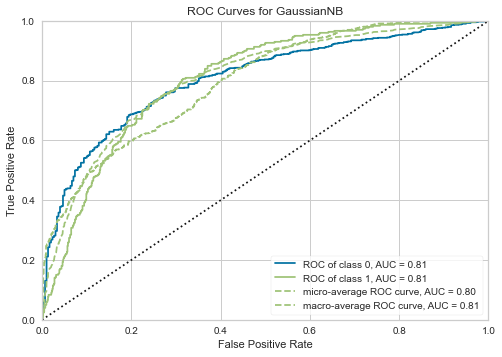

In [26]:
# AUC-ROC plot
pyc.plot_model(model_best, plot = 'auc')

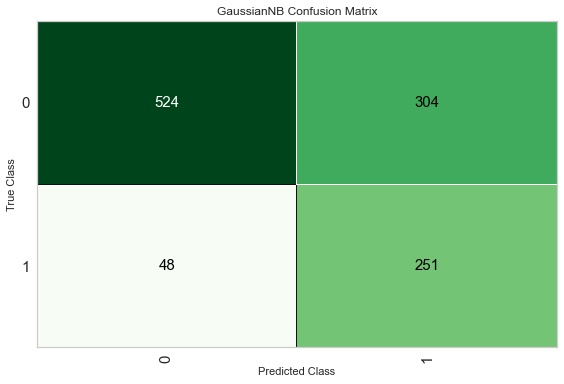

In [27]:
# confusion matrix
pyc.plot_model(model_best, plot = 'confusion_matrix')

In [28]:
# evaluate model (click on buttons)
pyc.evaluate_model(model_best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

<a id="" ></a>

<h1>  Model Calibration</h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.calibrate_model(
    estimator,
    method     = 'sigmoid',
    fold       = None,
    round      = 4,
    fit_kwargs = None,
    groups     = None,
    verbose    = True,
)
```

In [29]:
# pyc.calibrate_model?

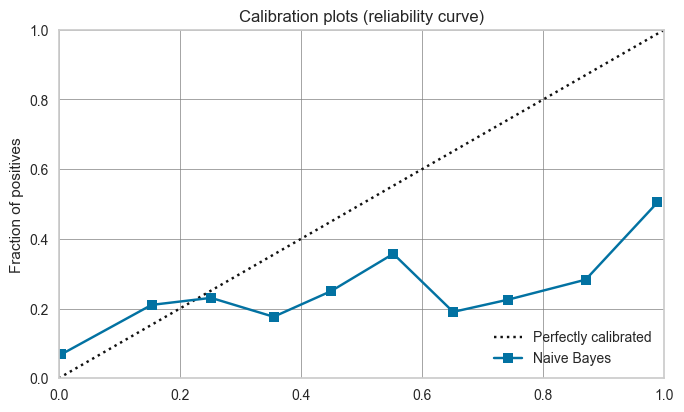

In [30]:
pyc.plot_model(model_best, plot='calibration')

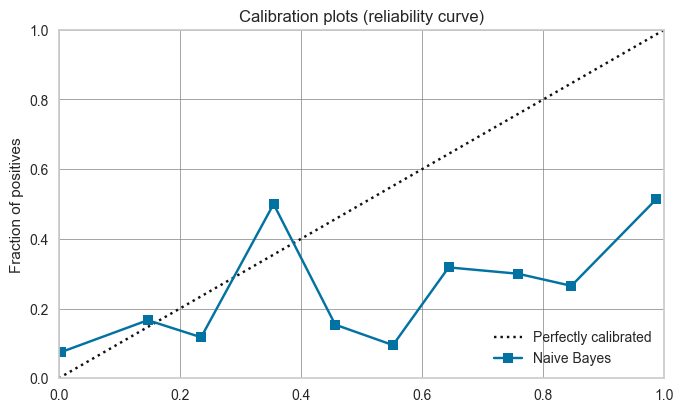

In [31]:
model_best_calibrated = pyc.calibrate_model(model_best,method='sigmoid',
                                            fold=5,verbose=False)
pyc.plot_model(model_best_calibrated, plot='calibration')
mean_row = pyc.pull().loc['Mean']
desc = 'tuned+calibrated'
df_eval = compare_new_models(model_name,desc,mean_row,sort='Recall',df_eval=df_eval)


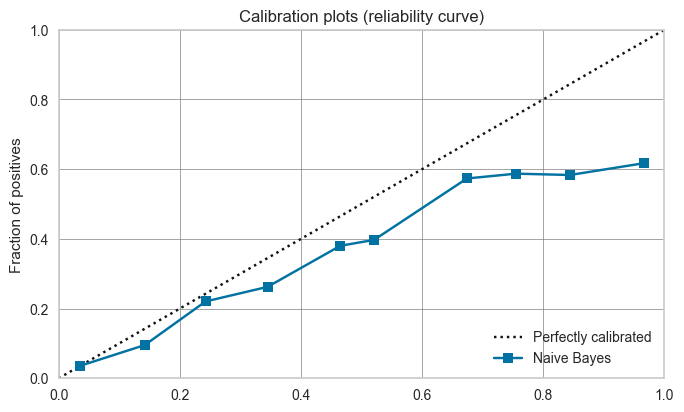

In [32]:
model_best_calibrated_iso = pyc.calibrate_model(model_best,method='isotonic',fold=5)
pyc.plot_model(model_best_calibrated_iso, plot='calibration')

mean_row = pyc.pull().loc['Mean']
desc = 'tuned+calibrated_iso'
df_eval = compare_new_models(model_name,desc,mean_row,sort='Recall',df_eval=df_eval)


<a id="" ></a>

<h1>  Model Interpretation of Tree Methods (Training) </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.interpret_model(
    estimator,
    plot           = 'summary',
    feature        = None,
    observation    = None,
    use_train_data = False,
    **kwargs,
)
```

- not supported models: logistic regression, nb
- supported models : rf, xgboost, lightgbm, catboost, dt, et

In [33]:
# pyc.interpret_model?

In [34]:
# interpret_model: SHAP
# pyc.interpret_model(model_best_lr)

# note: logistic regression is not supported
# supported: rf, xgboost, lightgbm, catboost, dt, et

In [35]:
# interpret model : Correlation
# pyc.interpret_model(model_best_lr,plot='correlation')

In [36]:
# interpret model : Reason
# pyc.interpret_model(model_best_lr,plot='reason',obervation=12)

<a id="" ></a>

<h1>  Model Prediction </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.predict_model(
    estimator,
    data                  = None,
    probability_threshold = None,
    encoded_labels        = False,
    round                 = 4,
    verbose               = True,
) -> pandas.core.frame.DataFrame
```

In [37]:
# pyc.predict_model?

In [38]:
df_test.iloc[:5,-5:]

Contract_totCharges_diff  PayMeth_mean_monthCharges  \
0              -1313.937095                  67.437658   
1               1902.661398                  67.437658   
2               1880.912905                  63.914865   
3              -3545.288602                  63.914865   
4              -3415.038602                  67.437658   

   PayMeth_monthCharges_diff  Tenure_cat  MonthlyCharges_cat  
0                 -18.837658           0                   0  
1                  32.462342           4                   0  
2                  40.285135           2                   0  
3                 -44.214865           1                   0  
4                 -47.387658           1                   0

In [39]:
df_preds = pyc.predict_model(model_best,df_test)
df_preds.iloc[:5,-5:]

PayMeth_monthCharges_diff  Tenure_cat  MonthlyCharges_cat  Label   Score
0                 -18.837658           0                   0      1  0.9939
1                  32.462342           4                   0      0  1.0000
2                  40.285135           2                   0      1  0.6701
3                 -44.214865           1                   0      0  1.0000
4                 -47.387658           1                   0      0  1.0000

<a id="" ></a>

<h1>  Model Persistence </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.save_model(
    model,
    model_name,
    model_only = False,
    verbose    = True,
)
```

In [40]:
# pyc.save_model?

In [41]:
if 'google.colab' in sys.modules:
    h = ''
else:
    h = "../models/"

In [42]:
# save the model
path_model = h + 'model_best_nb_pycaret'
pyc.save_model(model_best, path_model)

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='Churn',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strat...
                 ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='Churn')),
                 ('fix_perfect', Remove_100(target='Churn')),
                 ('clean_names', Cl

In [43]:
# load model
model_best_pipe = pyc.load_model(model_name=path_model)

Transformation Pipeline and Model Successfully Loaded


<a id="" ></a>

<h1>  Finalize model (Fit whole train data) </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.finalize_model(
    estimator,
    fit_kwargs = None,
    group      = None,
    model_only = True,
)

Docstring:
This function trains a given estimator on the entire dataset including the 
holdout set.
```

In [44]:
# pyc.finalize_model?

In [45]:
# final_model = pyc.finalize_model(model_best)
# print(final_model)

# This will fail, we have used pyc.load_model (model_best_pipe)

<a id="" ></a>

<h1>  Model Evaluation on Test Data </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [46]:
# since the pyc.finalize fails when we use pyc.load_model,
# I will fit the model on whole data and
# then will predict on test data as usual way.

In [47]:
model_best_pipe

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='Churn',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strat...
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='Churn')),
                ('fix_perfect', Remove_100(target='Churn')),
                ('clean_names', Clean_Colum_Names())

In [48]:
model_best_pipe[-1]

GaussianNB(priors=None, var_smoothing=4.54485903218079e-08)

In [49]:
from sklearn.naive_bayes import GaussianNB

In [50]:
model = GaussianNB(priors=None, var_smoothing=4.282763591903976e-08)

In [51]:
model.fit(df_train.drop(target_name,axis=1), df_train[target_name])

GaussianNB(priors=None, var_smoothing=4.282763591903976e-08)

In [52]:
show_methods(model)

0            1                  2              3
0  class_count_          fit  predict_log_proba     set_params
1  class_prior_   get_params      predict_proba         sigma_
2      classes_  partial_fit             priors         theta_
3      epsilon_      predict              score  var_smoothing

In [53]:
yprobs = model.predict_proba(df_test.drop(target_name,axis=1))
yprobs[:5].round(4)

array([[0.0075, 0.9925],
       [1.    , 0.    ],
       [0.0426, 0.9574],
       [1.    , 0.    ],
       [1.    , 0.    ]])

In [54]:
# first column is prob of 0 and second is 1
ypreds = np.array([1 if y>x else 0 for x,y in yprobs])
ypreds[:5]

array([1, 0, 1, 0, 0])

In [55]:
ytest = df_test[target_name].to_numpy().ravel()
ytest[:5]

array([1, 0, 1, 0, 0])

In [56]:
import sklearn.metrics as skmetrics

report = f"""
Accuracy  : {skmetrics.accuracy_score(ytest,ypreds):.4f}
Precision : {skmetrics.precision_score(ytest,ypreds):.4f}
Recall    : {skmetrics.recall_score(ytest,ypreds):.4f}
F1-score  : {skmetrics.f1_score(ytest,ypreds):.4f}
"""
print(report)

print(skmetrics.classification_report(ytest,ypreds))
# look at the value of recall for 1. It must be nearer to 1.

print(skmetrics.confusion_matrix(ytest,ypreds))


Accuracy  : 0.7296
Precision : 0.4943
Recall    : 0.8102
F1-score  : 0.6140

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1035
           1       0.49      0.81      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.76      0.70      1409
weighted avg       0.80      0.73      0.74      1409

[[725 310]
 [ 71 303]]


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

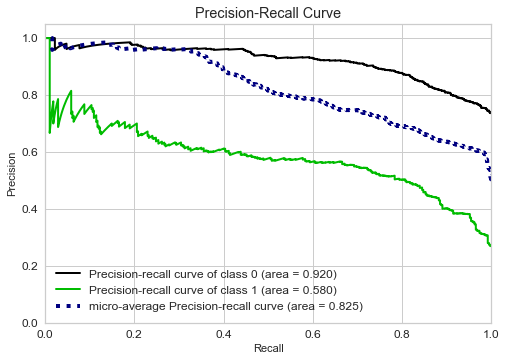

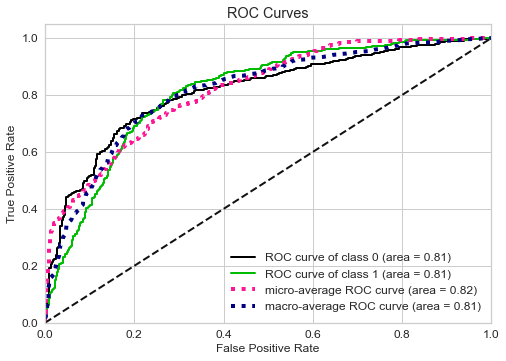

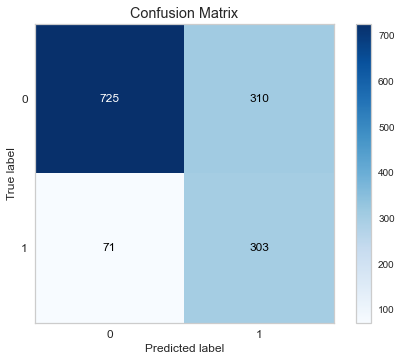

In [57]:
import scikitplot.metrics as skpmetrics

skpmetrics.plot_precision_recall(ytest,yprobs)
skpmetrics.plot_roc_curve(ytest,yprobs)
skpmetrics.plot_confusion_matrix(ytest,ypreds)

In [58]:
"""
There are total  374 churn cases in test dataset (20% of full data with seed=100)
Out of which only 303 are correctly classified.

This is great an improvement.
The dataset it highly imbalanced. The dumb classifier will classify
everything as non-churn.
""";

<a id="" ></a>

<h1>  Time Taken </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [59]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

Time taken to run whole notebook: 0 hr 1 min 14 secs
